<a href="https://colab.research.google.com/github/SaiDeepika2004/Alzheimers_disease_detection/blob/main/PROJECT_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP-1 : Importing all the necessary libraries for the model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, Input, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt


In [ ]:
# STEP-2 : Loading our Dataset & preprocessing before training models
# Loading the dataset
df = pd.read_csv("alzheimers_disease_data_expanded_3 (3).csv")

# Dropping the redundant columns
df.drop(columns=["PatientID", "DoctorInCharge"], inplace=True)

X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handling the Class Imbalances using SMOTE Technique
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Data Split - 80% TRAIN & 20% TEST
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [ ]:
# STEP-3 : Selection of best features using DT & RF models
# Decision Tree
dt = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
dt.fit(X_train, y_train)
dt_importances = dt.feature_importances_

# Random Forest
rf = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train, y_train)
rf_importances = rf.feature_importances_

# Selecting the top features (15 from DT & RF)
dt_top_features = set(np.argsort(dt_importances)[-15:])
rf_top_features = set(np.argsort(rf_importances)[-15:])
selected_features = list(dt_top_features.intersection(rf_top_features))

feature_names = X.columns[selected_features]
print("Selected features:", feature_names.tolist())

X_train_selected = X_train[:, selected_features].astype(np.float32)
X_test_selected = X_test[:, selected_features].astype(np.float32)

Selected features: ['Age', 'BMI', 'DietQuality', 'SleepQuality', 'CholesterolTotal', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']


In [ ]:
# STEP-4 : Before giving the data to CNN, we perform the reshaping of the data
# Reshaping for CNN input
X_train_selected_cnn = X_train_selected.reshape(X_train_selected.shape[0], X_train_selected.shape[1], 1)
X_test_selected_cnn = X_test_selected.reshape(X_test_selected.shape[0], X_test_selected.shape[1], 1)

In [ ]:
# STEP-5 : Defining the CNN model architechture
cnn_input = Input(shape=(X_train_selected.shape[1], 1))
cnn_layer = Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(cnn_input)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0005))(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Flatten()(cnn_layer)
cnn_layer = Dense(1024, activation='relu', kernel_regularizer=l2(0.0005))(cnn_layer)
cnn_layer = BatchNormalization()(cnn_layer)
cnn_layer = Dropout(0.4)(cnn_layer)

In [ ]:
# STEP-6 : Defining the ANN model architechture
ann_input = Input(shape=(X_train_selected.shape[1],))
ann_layer = Dense(1024, activation='relu', kernel_regularizer=l2(0.0005))(ann_input)
ann_layer = BatchNormalization()(ann_layer)
ann_layer = Dropout(0.5)(ann_layer)
ann_layer = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(ann_layer)
ann_layer = BatchNormalization()(ann_layer)
ann_layer = Dropout(0.4)(ann_layer)
ann_layer = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(ann_layer)
ann_layer = BatchNormalization()(ann_layer)
ann_layer = Dropout(0.3)(ann_layer)

In [ ]:
# STEP-7 : Merging both the CNN, ANN models
merged_layer = Concatenate()([cnn_layer, ann_layer])
merged_layer = Dense(1024, activation='relu', kernel_regularizer=l2(0.0005))(merged_layer)
merged_layer = BatchNormalization()(merged_layer)
merged_layer = Dropout(0.3)(merged_layer)
merged_layer = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(merged_layer)
merged_layer = BatchNormalization()(merged_layer)
merged_layer = Dropout(0.3)(merged_layer)
merged_layer = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(merged_layer)
merged_layer = BatchNormalization()(merged_layer)
merged_layer = Dropout(0.3)(merged_layer)
output_layer = Dense(1, activation='sigmoid')(merged_layer)

# Creating the final Model
final_model = Model(inputs=[cnn_input, ann_input], outputs=output_layer)

In [ ]:
# STEP-8 : Compiling the model and defining the model callbacks to prevent overfitting
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
final_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_lr=0.000001, mode='max')

# Train the Model
history = final_model.fit(
    [X_train_selected_cnn, X_train_selected],
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=([X_test_selected_cnn, X_test_selected], y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1,
    class_weight={0: 1, 1: 1.5}
)


Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.7030 - loss: 3.3686 - val_accuracy: 0.7303 - val_loss: 3.1431 - learning_rate: 5.0000e-04
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8264 - loss: 3.1069 - val_accuracy: 0.7537 - val_loss: 3.0713 - learning_rate: 5.0000e-04
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8537 - loss: 2.9919 - val_accuracy: 0.8867 - val_loss: 2.7788 - learning_rate: 5.0000e-04
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8662 - loss: 2.8907 - val_accuracy: 0.8953 - val_loss: 2.7110 - learning_rate: 5.0000e-04
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8733 - loss: 2.7858 - val_accuracy: 0.9150 - val_loss: 2.6126 - learning_rate: 5.0000e-04
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8880 - loss: 2.6905 - val_accuracy: 0.9323 - val_loss: 2.4905 - learning_rate: 5.0000e-04
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - a

In [ ]:
# STEP-9 : Evaluating the model and then displaying the performance metrics
# Model Predictions
y_pred = final_model.predict([X_test_selected_cnn, X_test_selected])
y_pred_classes = (y_pred > 0.5).astype(int)

# Classification Report of the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Final Test Accuracy
loss, accuracy = final_model.evaluate([X_test_selected_cnn, X_test_selected], y_test, verbose=0)
print(f'\nFinal Test Accuracy: {accuracy * 100:.2f}%')

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       406
           1       0.97      0.97      0.97       406

    accuracy                           0.97       812
   macro avg       0.97      0.97      0.97       812
weighted avg       0.97      0.97      0.97       812


Confusion Matrix:
[[393  13]
 [ 11 395]]

Final Test Accuracy: 97.04%


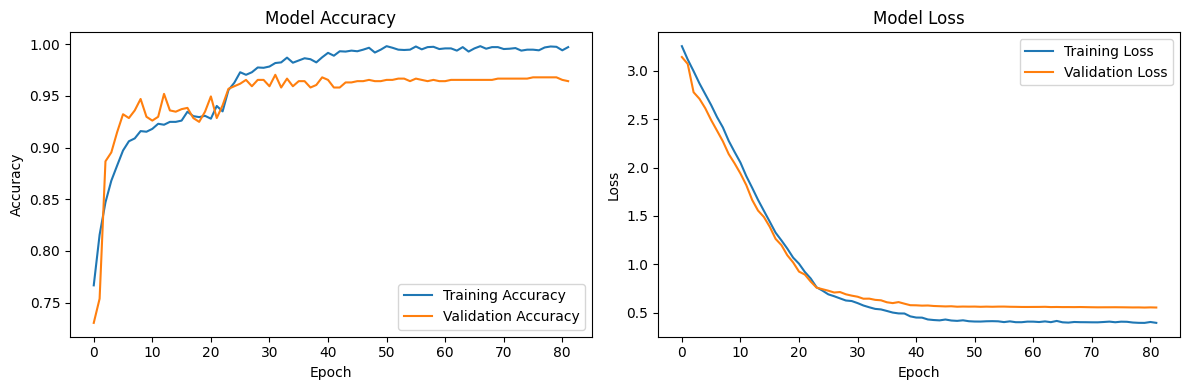

In [ ]:
# STEP-10: Visualization of the Training History
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

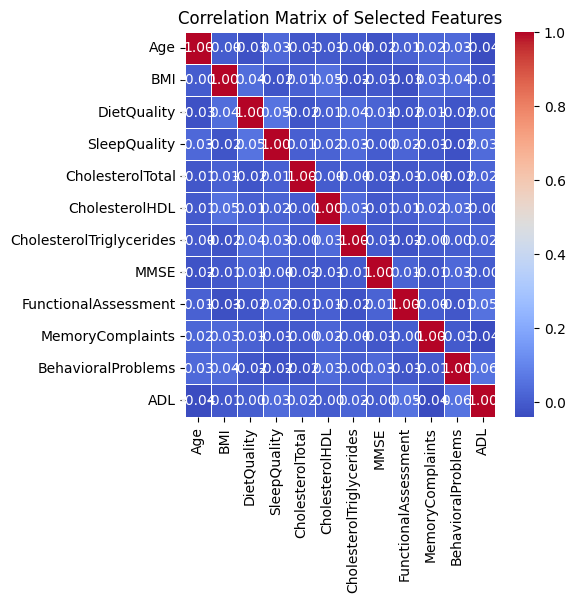

In [ ]:
# Correlation matrix of the selected features
import seaborn as sns
import matplotlib.pyplot as plt

# Converting the selected features indices to column names
selected_feature_names = X.columns[selected_features]

# Extracting the selected features from the original dataset
df_selected = df[selected_feature_names]

corr_matrix = df_selected.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = y_test
y_pred = y_pred_classes

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

metrics_dict = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}

for metric, value in metrics_dict.items():
    print(f"{metric}: {value:.4f}")


Accuracy: 0.9704
Precision: 0.9705
Recall: 0.9704
F1-Score: 0.9704


(0.9, 1.0)

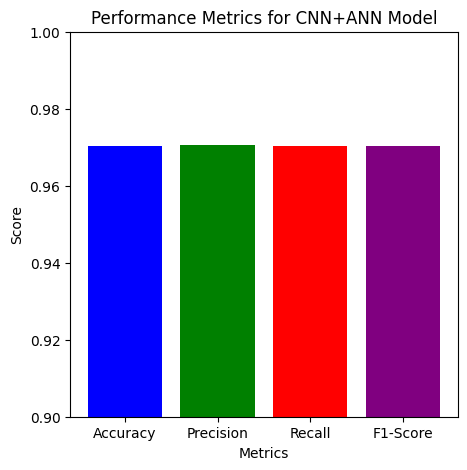

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [accuracy, precision, recall, f1]

# Colors for bars
colors = ['blue', 'green', 'red', 'purple']

# Bar chart
plt.figure(figsize=(5, 5))
plt.bar(metrics, scores, color=colors)

# Labels and title
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Performance Metrics for CNN+ANN Model")
plt.ylim(0.9, 1.0)

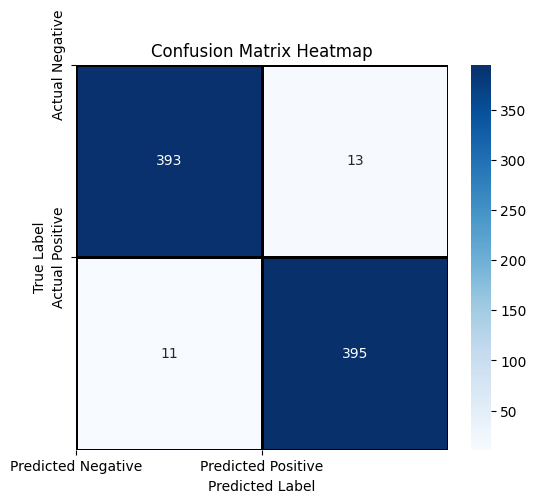

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = y_pred_classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting  the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=1, linecolor='black')

# labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")

plt.xticks(ticks=[0, 1], labels=["Predicted Negative", "Predicted Positive"])
plt.yticks(ticks=[0, 1], labels=["Actual Negative", "Actual Positive"])

plt.show()


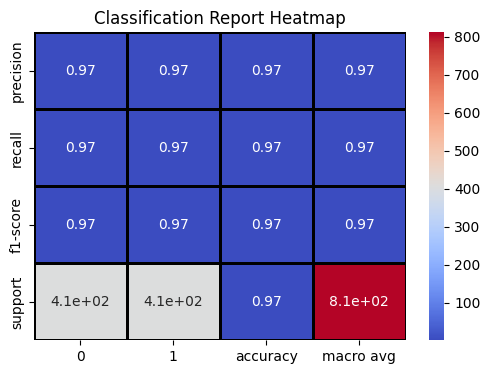

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(6, 4))
sns.heatmap(df_report.iloc[:-1, :].T, annot=True, cmap="coolwarm", linewidths=1, linecolor="black")
plt.title("Classification Report Heatmap")
plt.show()

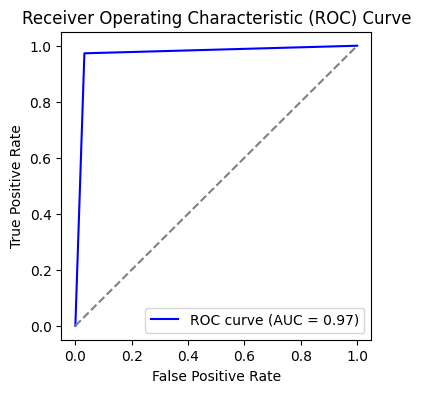

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

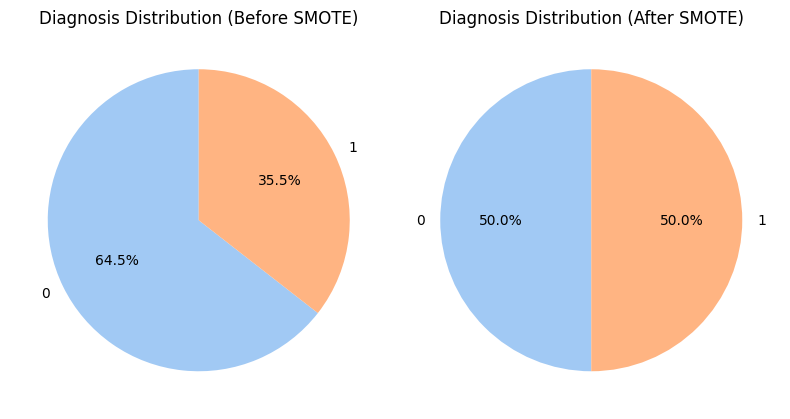

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("alzheimers_disease_data_expanded_3 (3).csv")

df = df.drop(columns=["PatientID", "DoctorInCharge"])

X = df.drop(columns=["Diagnosis"])
y = df["Diagnosis"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

before_counts = Counter(y)
after_counts = Counter(y_resampled)

# Plotting Pie Charts
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

# Before SMOTE
axes[0].pie(before_counts.values(), labels=before_counts.keys(), autopct='%1.1f%%',
            colors=sns.color_palette("pastel"), startangle=90)
axes[0].set_title("Diagnosis Distribution (Before SMOTE)")

# After SMOTE
axes[1].pie(after_counts.values(), labels=after_counts.keys(), autopct='%1.1f%%',
            colors=sns.color_palette("pastel"), startangle=90)
axes[1].set_title("Diagnosis Distribution (After SMOTE)")

plt.tight_layout()
plt.show()
